### Курсовая

In [2]:
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [4]:
# процедура для отображения результатов
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [5]:
DATASET_PATH = 'train.csv'
SCALER_FILE_PATH = 'model_train3.pkl'
MODEL_FILE_PATH = 'scaler_train3.pkl'

Обрабатываем train.csv

In [6]:
df = pd.read_csv(DATASET_PATH)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


Приведение типов данных

In [8]:
# Для удобства обработки переводим int во float
df['Id']=df['Id'].astype(float)
df['DistrictId']=df['DistrictId'].astype(float)
df['Floor']=df['Floor'].astype(float)
df['HouseYear']=df['HouseYear'].astype(float)
df['Social_1']=df['Social_1'].astype(float)
df['Social_2']=df['Social_2'].astype(float)
df['Social_3']=df['Social_3'].astype(float)
df['Helthcare_2']=df['Helthcare_2'].astype(float)
df['Shops_1']=df['Shops_1'].astype(float)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null float64
DistrictId       10000 non-null float64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null float64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null float64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null float64
Social_2         10000 non-null float64
Social_3         10000 non-null float64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null float64
Shops_1          10000 non-null float64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(17), object(3)
memory usage: 1.5+ MB


Обзор количественных переменных

In [10]:
df_num=df.select_dtypes(include = ['float64'])
df_num.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


 Заполняем пропуски в LifeSquare и Healthcare_1 медианами

In [11]:
missing_LifeSquare = df.loc[df['LifeSquare'].isnull(),'LifeSquare']
missing_LifeSquare[:5]

7    NaN
8    NaN
21   NaN
23   NaN
25   NaN
Name: LifeSquare, dtype: float64

In [12]:
df.loc[df['LifeSquare'].isnull(),'LifeSquare']=df['LifeSquare'].median()
df.loc[20:25,'LifeSquare']

20    47.799426
21    32.781260
22    20.207762
23    32.781260
24    44.169694
25    32.781260
Name: LifeSquare, dtype: float64

In [13]:
missing_Healthcare_1 = df.loc[df['Healthcare_1'].isnull(),'Healthcare_1']
missing_Healthcare_1[:5]

0   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: Healthcare_1, dtype: float64

In [14]:
df.loc[df['Healthcare_1'].isnull(),'Healthcare_1']=df['Healthcare_1'].median()

проверяем и обабатываем выбросы

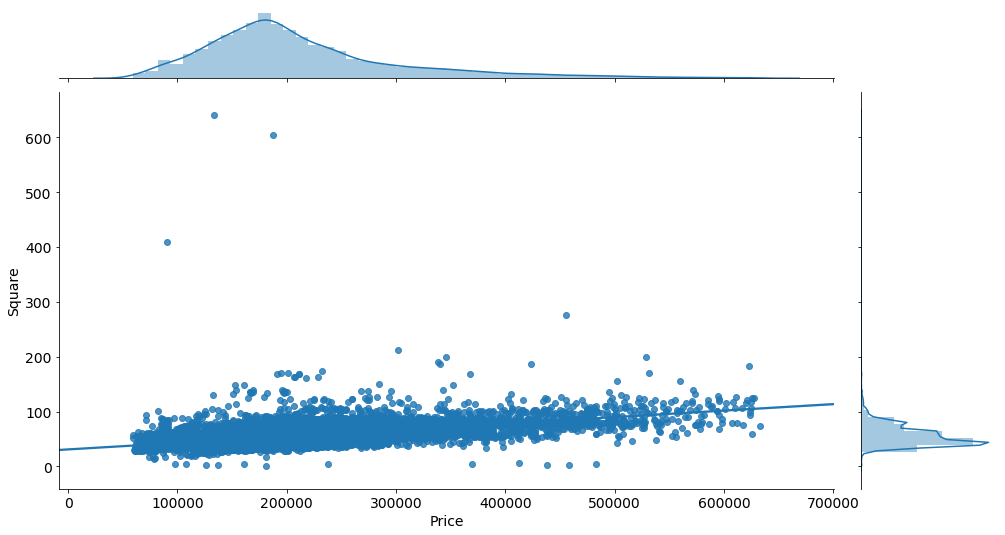

In [15]:
grid_1 = sns.jointplot(df['Price'],df['Square'], kind = 'reg')
grid_1.fig.set_figwidth(16)
grid_1.fig.set_figheight(8)
plt.show()

In [16]:
df.loc[df['Square']>200]=df['Square'].median()

In [17]:
# Проверяем, где общая площадь меньше 15
df.loc[df['Square']<15,'Square']

212      5.497061
1316     4.633498
1608     2.596351
3280     4.380726
3413     5.129222
4739    13.784865
4853     2.377248
4900     4.390331
6392     1.136859
8030     4.823679
8283     1.988943
9294     2.954309
9613     4.502784
Name: Square, dtype: float64

In [18]:
df.loc[df['Square']<15]=df['Square'].median()

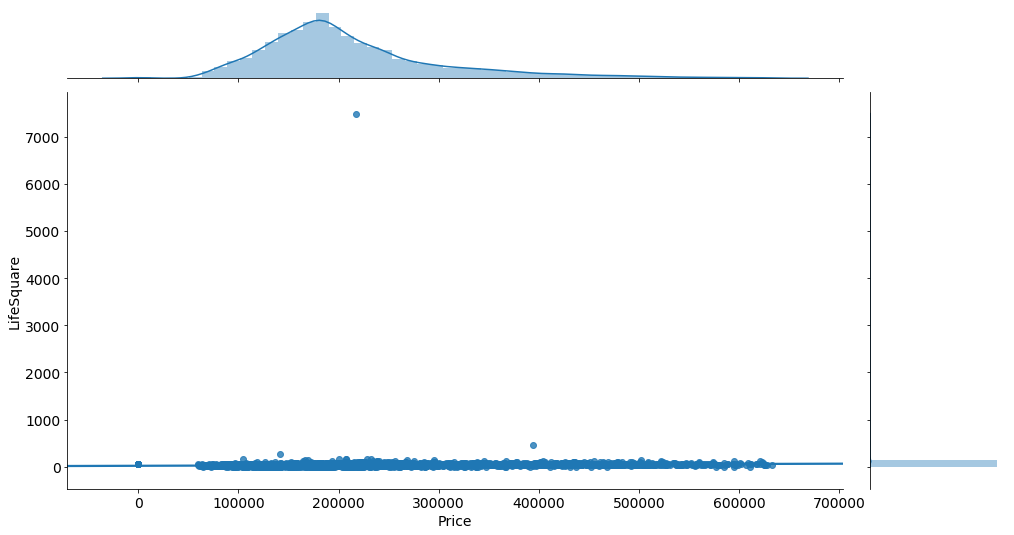

In [19]:
grid_1 = sns.jointplot(df['Price'],df['LifeSquare'], kind = 'reg')
grid_1.fig.set_figwidth(16)
grid_1.fig.set_figheight(8)
plt.show()

In [20]:
df.loc[df['LifeSquare']>150]=df['LifeSquare'].median()

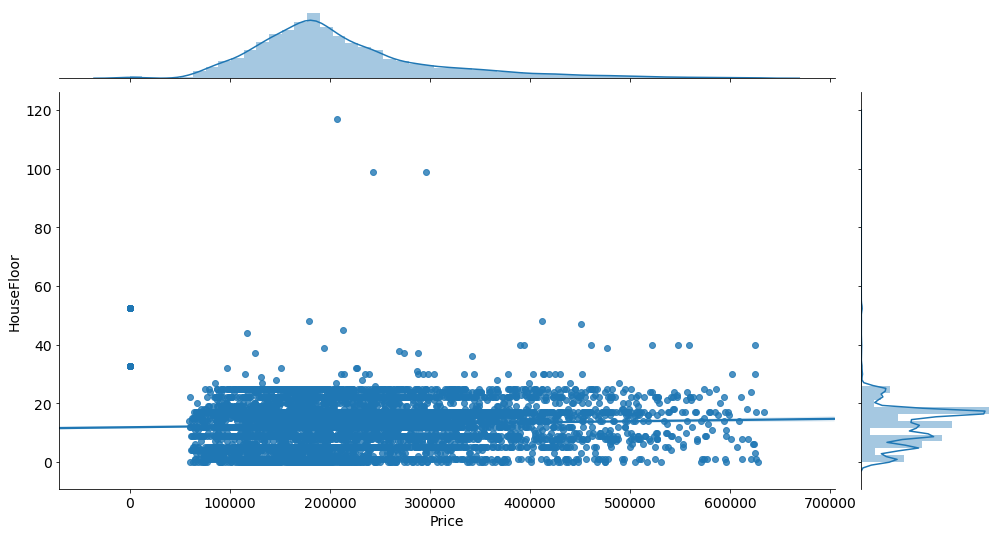

In [21]:
grid_1 = sns.jointplot(df['Price'],df['HouseFloor'], kind = 'reg')
grid_1.fig.set_figwidth(16)
grid_1.fig.set_figheight(8)
plt.show()

In [22]:
df.loc[df['HouseFloor']>40]=df['HouseFloor'].median()

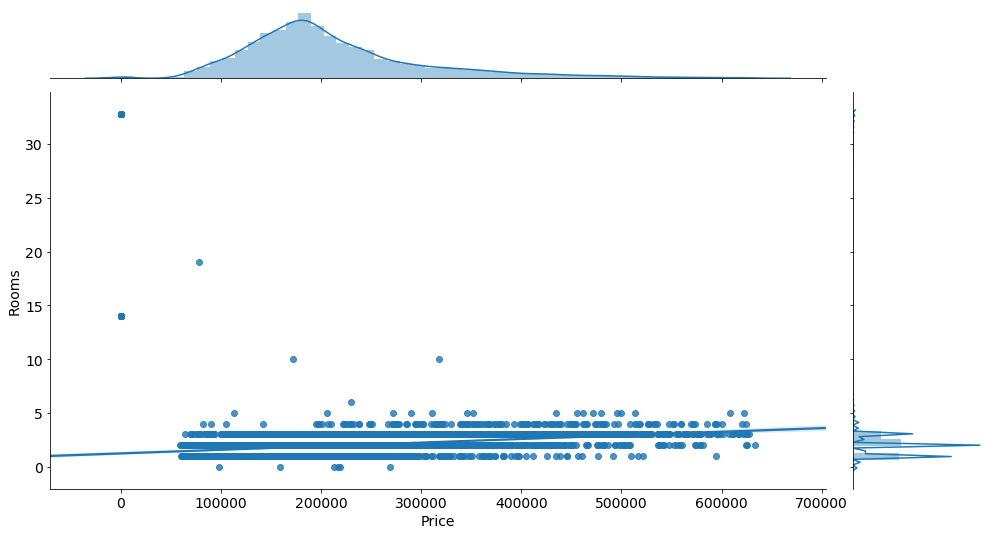

In [23]:
grid_1 = sns.jointplot(df['Price'],df['Rooms'], kind = 'reg')
grid_1.fig.set_figwidth(16)
grid_1.fig.set_figheight(8)
plt.show()

In [24]:
df.loc[df['Rooms']>=10]=df['Rooms'].median()

In [25]:
# Проверяем данные, где жилая площадь больше общей
df.loc[df['LifeSquare']>df['Square'],'LifeSquare']

28       43.967759
44      106.340403
52       65.224603
123      89.803753
153      53.491301
           ...    
9884     59.439082
9889     53.134243
9895    125.806981
9902     44.267551
9961     32.781260
Name: LifeSquare, Length: 499, dtype: float64

In [26]:
# Медиана
df.loc[df['LifeSquare']>=df['Square']]=df['LifeSquare'].median()

In [27]:
# Смотрим данные, где Rooms нулевой
df.loc[df['Rooms']<=0,'Rooms']

1397    0.0
2269    0.0
3911    0.0
4366    0.0
6149    0.0
8834    0.0
Name: Rooms, dtype: float64

In [28]:
# Заменяем на медиану
df.loc[df['Rooms']<=0,'Rooms']=df['Rooms'].median()

In [29]:
# Заменяем данные, где KitchenSquare нулевой, на медиану
df.loc[df['KitchenSquare']<=0,'KitchenSquare']=df['KitchenSquare'].median()

In [30]:
# Проверяем данные HouseYear, где год заведомо неверен
df.loc[df['HouseYear']>2019,'HouseYear']

585         2020.0
707         2020.0
790         2020.0
918         2020.0
1497    20052011.0
1499        2020.0
2493        2020.0
2877        2020.0
3357        2020.0
3859        2020.0
4189        4968.0
4376        2020.0
4493        2020.0
6735        2020.0
7076        2020.0
7459        2020.0
8253        2020.0
9674        2020.0
Name: HouseYear, dtype: float64

In [31]:
# Заменяем ошибочные данные в HouseYear 1
df.loc[df['HouseYear']==20052011,'HouseYear']=2008
df.loc[df['HouseYear']==4968,'HouseYear']=2019

In [32]:
# Проверяем данные, где кухня больше общей площади
df.loc[df['KitchenSquare']>df['Square'],'KitchenSquare']

1064    2014.0
5149      73.0
7088      84.0
8584    1970.0
Name: KitchenSquare, dtype: float64

In [33]:
# Заменяем ошибочные данные на медиану
df.loc[df['KitchenSquare']>df['Square'],'KitchenSquare']=df['KitchenSquare'].median()

In [34]:
# Проверяем данные, где этаж выше, чем этажей в доме
df.loc[df['Floor']>df['HouseFloor'],'Floor']

7       14.0
14       5.0
16       6.0
21      15.0
23       2.0
        ... 
9984    11.0
9985    10.0
9989    26.0
9991    18.0
9995     6.0
Name: Floor, Length: 1682, dtype: float64

In [35]:
#делаем равным верхнему этажу
df.loc[df['Floor']>df['HouseFloor'],'Floor']=df['HouseFloor']

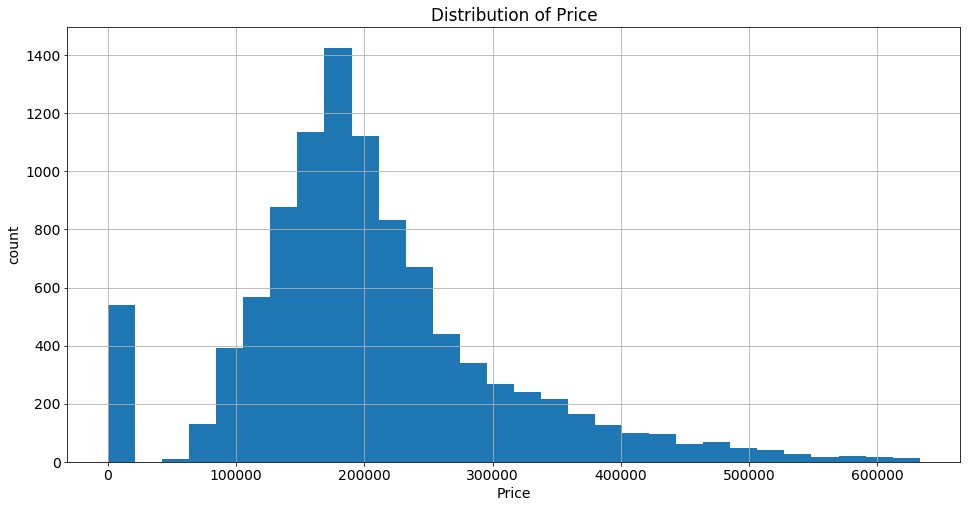

In [36]:
#проверяем распределение цены
plt.figure(figsize = (16, 8))
df['Price'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Distribution of Price')
plt.show()

In [37]:
df['Price'].value_counts().head()

32.781260        539
207103.209097      1
173430.164732      1
616857.135464      1
263205.900317      1
Name: Price, dtype: int64

In [38]:
df=df[df['Price']>50].reset_index()

In [39]:
df.head()

,index,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,...,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,0,14038.0,35.0,2.0,47.981561,29.442751,6.0,7.0,9.0,1969.0,...,B,B,33.0,7976.0,5.0,900.0,0.0,11.0,B,184966.930730
1,1,15053.0,41.0,3.0,65.683640,40.049543,8.0,7.0,9.0,1978.0,...,B,B,46.0,10309.0,1.0,240.0,1.0,16.0,B,300009.450063
2,2,4765.0,53.0,2.0,44.947953,29.197612,6.0,8.0,12.0,1968.0,...,B,B,34.0,7759.0,0.0,229.0,1.0,3.0,B,220925.908524
3,3,5809.0,58.0,2.0,53.352981,52.731512,9.0,8.0,17.0,1977.0,...,B,B,23.0,5735.0,3.0,1084.0,0.0,5.0,B,175616.227217
4,4,10783.0,99.0,1.0,39.649192,23.776169,7.0,11.0,12.0,1976.0,...,B,B,35.0,5776.0,1.0,2078.0,2.0,4.0,B,150226.531644


In [40]:
df.describe()

,index,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000
mean,4992.820421,8391.487686,51.412430,1.897897,56.103093,34.030788,6.378713,7.662932,12.527111,1984.082127,0.119862,25.253884,5461.852130,7.911214,1033.638939,1.343938,4.263291,215265.478540
std,2884.202168,4858.225760,44.127385,0.811087,18.474955,13.789316,4.500788,5.216092,6.455788,18.019924,0.119503,17.414528,3986.984092,23.241797,760.726060,1.494770,4.748953,92278.713261
min,0.000000,0.000000,0.000000,1.000000,16.117154,0.370619,1.000000,0.000000,0.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,2496.000000,4182.000000,20.000000,1.000000,41.891960,24.479166,5.000000,4.000000,9.000000,1973.000000,0.017647,8.000000,1892.000000,0.000000,810.000000,0.000000,1.000000,155518.223364
50%,4992.000000,8404.000000,38.000000,2.000000,52.539711,32.781260,6.000000,7.000000,12.000000,1977.000000,0.075779,25.000000,5288.000000,2.000000,900.000000,1.000000,3.000000,193226.230130
75%,7487.000000,12606.000000,78.000000,2.000000,65.845950,38.960935,9.000000,11.000000,17.000000,1999.000000,0.195781,36.000000,7425.000000,5.000000,1015.000000,2.000000,6.000000,250262.083336
max,9999.000000,16798.000000,209.000000,6.000000,198.930182,138.004600,112.000000,37.000000,40.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Обзор вещественных переменных

In [41]:
df_num=df.select_dtypes(include = ['object'])
df_num.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B


In [42]:
df_num.describe()

,Ecology_2,Ecology_3,Shops_2
count,9461,9461,9461
unique,2,2,2
top,B,B,B
freq,9364,9190,8700


In [43]:
df['Shops_2'].value_counts()

B    8700
A     761
Name: Shops_2, dtype: int64

In [44]:
df=pd.get_dummies(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9461 entries, 0 to 9460
Data columns (total 24 columns):
index            9461 non-null int64
Id               9461 non-null float64
DistrictId       9461 non-null float64
Rooms            9461 non-null float64
Square           9461 non-null float64
LifeSquare       9461 non-null float64
KitchenSquare    9461 non-null float64
Floor            9461 non-null float64
HouseFloor       9461 non-null float64
HouseYear        9461 non-null float64
Ecology_1        9461 non-null float64
Social_1         9461 non-null float64
Social_2         9461 non-null float64
Social_3         9461 non-null float64
Healthcare_1     9461 non-null float64
Helthcare_2      9461 non-null float64
Shops_1          9461 non-null float64
Price            9461 non-null float64
Ecology_2_A      9461 non-null uint8
Ecology_2_B      9461 non-null uint8
Ecology_3_A      9461 non-null uint8
Ecology_3_B      9461 non-null uint8
Shops_2_A        9461 non-null uint8
Shops_2_

Бинарные признаки

In [45]:
df_bin =df.select_dtypes(include = 'uint8')
df_bin

,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,0,1,0,1,0,1
1,0,1,0,1,0,1
2,0,1,0,1,0,1
3,0,1,0,1,0,1
4,0,1,0,1,0,1
...,...,...,...,...,...,...
9456,0,1,0,1,0,1
9457,0,1,0,1,1,0
9458,0,1,0,1,1,0
9459,0,1,1,0,0,1


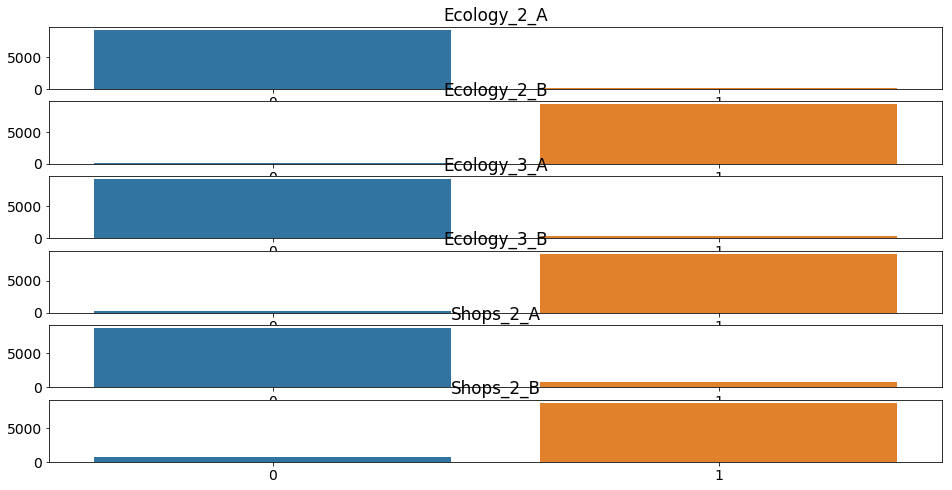

In [46]:
plt.figure(figsize=(16,8))
for i, col_name in enumerate(df_bin.columns):
    counts = df_bin[col_name].value_counts()
    plt.subplot(6,1,i+1)
    plt.title(col_name)
    sns.barplot(counts.index, counts.values)
plt.show()

In [47]:
df.head()

,index,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,0,14038.0,35.0,2.0,47.981561,29.442751,6.0,7.0,9.0,1969.0,...,900.0,0.0,11.0,184966.930730,0,1,0,1,0,1
1,1,15053.0,41.0,3.0,65.683640,40.049543,8.0,7.0,9.0,1978.0,...,240.0,1.0,16.0,300009.450063,0,1,0,1,0,1
2,2,4765.0,53.0,2.0,44.947953,29.197612,6.0,8.0,12.0,1968.0,...,229.0,1.0,3.0,220925.908524,0,1,0,1,0,1
3,3,5809.0,58.0,2.0,53.352981,52.731512,9.0,8.0,17.0,1977.0,...,1084.0,0.0,5.0,175616.227217,0,1,0,1,0,1
4,4,10783.0,99.0,1.0,39.649192,23.776169,7.0,11.0,12.0,1976.0,...,2078.0,2.0,4.0,150226.531644,0,1,0,1,0,1


In [48]:
# исключаем ID и Index
df=df[df.columns[2:]]
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,35.0,2.0,47.981561,29.442751,6.0,7.0,9.0,1969.0,0.089040,33.0,...,900.0,0.0,11.0,184966.930730,0,1,0,1,0,1
1,41.0,3.0,65.683640,40.049543,8.0,7.0,9.0,1978.0,0.000070,46.0,...,240.0,1.0,16.0,300009.450063,0,1,0,1,0,1
2,53.0,2.0,44.947953,29.197612,6.0,8.0,12.0,1968.0,0.049637,34.0,...,229.0,1.0,3.0,220925.908524,0,1,0,1,0,1
3,58.0,2.0,53.352981,52.731512,9.0,8.0,17.0,1977.0,0.437885,23.0,...,1084.0,0.0,5.0,175616.227217,0,1,0,1,0,1
4,99.0,1.0,39.649192,23.776169,7.0,11.0,12.0,1976.0,0.012339,35.0,...,2078.0,2.0,4.0,150226.531644,0,1,0,1,0,1


In [49]:
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000,...,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000,9461.000000
mean,51.412430,1.897897,56.103093,34.030788,6.378713,7.662932,12.527111,1984.082127,0.119862,25.253884,...,1033.638939,1.343938,4.263291,215265.478540,0.010253,0.989747,0.028644,0.971356,0.080435,0.919565
std,44.127385,0.811087,18.474955,13.789316,4.500788,5.216092,6.455788,18.019924,0.119503,17.414528,...,760.726060,1.494770,4.748953,92278.713261,0.100740,0.100740,0.166812,0.166812,0.271981,0.271981
min,0.000000,1.000000,16.117154,0.370619,1.000000,0.000000,0.000000,1910.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.891960,24.479166,5.000000,4.000000,9.000000,1973.000000,0.017647,8.000000,...,810.000000,0.000000,1.000000,155518.223364,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,38.000000,2.000000,52.539711,32.781260,6.000000,7.000000,12.000000,1977.000000,0.075779,25.000000,...,900.000000,1.000000,3.000000,193226.230130,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,78.000000,2.000000,65.845950,38.960935,9.000000,11.000000,17.000000,1999.000000,0.195781,36.000000,...,1015.000000,2.000000,6.000000,250262.083336,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,209.000000,6.000000,198.930182,138.004600,112.000000,37.000000,40.000000,2020.000000,0.521867,74.000000,...,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [50]:
df.shape

(9461, 22)

In [51]:
#сохраняем обработанные данные -- 
df.to_csv('train_prepared3.csv',index=False)

In [94]:
#Загрудаем обработанные данные. Далее работаем с ними
df = pd.read_csv('train_prepared3.csv')
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,35.0,2.0,47.981561,29.442751,6.0,7.0,9.0,1969.0,0.089040,33.0,...,900.0,0.0,11.0,184966.930730,0,1,0,1,0,1
1,41.0,3.0,65.683640,40.049543,8.0,7.0,9.0,1978.0,0.000070,46.0,...,240.0,1.0,16.0,300009.450063,0,1,0,1,0,1
2,53.0,2.0,44.947953,29.197612,6.0,8.0,12.0,1968.0,0.049637,34.0,...,229.0,1.0,3.0,220925.908524,0,1,0,1,0,1
3,58.0,2.0,53.352981,52.731512,9.0,8.0,17.0,1977.0,0.437885,23.0,...,1084.0,0.0,5.0,175616.227217,0,1,0,1,0,1
4,99.0,1.0,39.649192,23.776169,7.0,11.0,12.0,1976.0,0.012339,35.0,...,2078.0,2.0,4.0,150226.531644,0,1,0,1,0,1


### Матрица корреляций

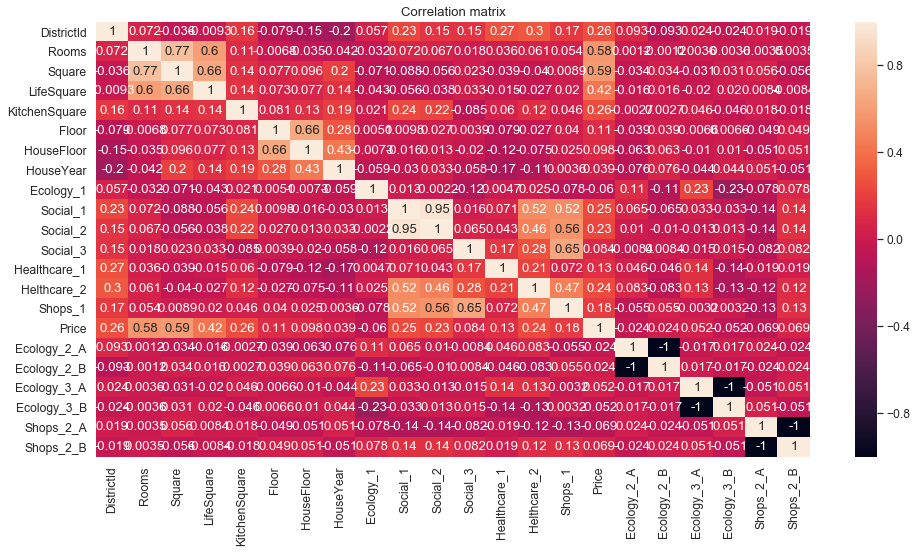

In [71]:
plt.figure(figsize=(16,8))
sns.set(font_scale = 1.1)
sns.heatmap(df.corr(), annot = True)
plt.title('Correlation matrix')
plt.show()

### Отбор признаков

In [95]:
df.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

In [96]:
feature_=['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B'
 ]
target_='Price'

In [97]:
df=df[feature_+[target_]]
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Price
0,35.0,2.0,47.981561,29.442751,6.0,7.0,9.0,1969.0,0.089040,33.0,...,900.0,0.0,11.0,0,1,0,1,0,1,184966.930730
1,41.0,3.0,65.683640,40.049543,8.0,7.0,9.0,1978.0,0.000070,46.0,...,240.0,1.0,16.0,0,1,0,1,0,1,300009.450063
2,53.0,2.0,44.947953,29.197612,6.0,8.0,12.0,1968.0,0.049637,34.0,...,229.0,1.0,3.0,0,1,0,1,0,1,220925.908524
3,58.0,2.0,53.352981,52.731512,9.0,8.0,17.0,1977.0,0.437885,23.0,...,1084.0,0.0,5.0,0,1,0,1,0,1,175616.227217
4,99.0,1.0,39.649192,23.776169,7.0,11.0,12.0,1976.0,0.012339,35.0,...,2078.0,2.0,4.0,0,1,0,1,0,1,150226.531644


### Стандартизация признаков

In [98]:
feature_stand = df[feature_].select_dtypes(include = 'float64').columns.tolist()
feature_stand

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1']

In [99]:
scl = StandardScaler()
scl_f = scl.fit_transform(df[feature_stand])
df[feature_stand]=pd.DataFrame(scl_f,columns=feature_stand)
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Price
0,-0.371953,0.125891,-0.439620,-0.332742,-0.084148,-0.127100,-0.546378,-0.837014,-0.257934,0.444831,...,-0.175682,-0.899141,1.418642,0,1,0,1,0,1,184966.930730
1,-0.235975,1.358871,0.518597,0.436503,0.360242,-0.127100,-0.546378,-0.337540,-1.002469,1.191374,...,-1.043320,-0.230107,2.471562,0,1,0,1,0,1,300009.450063
2,0.035979,0.125891,-0.603830,-0.350520,-0.084148,0.064624,-0.081654,-0.892511,-0.587670,0.502258,...,-1.057781,-0.230107,-0.266029,0,1,0,1,0,1,220925.908524
3,0.149293,0.125891,-0.148864,1.356247,0.582437,0.064624,0.692886,-0.393037,2.661350,-0.129432,...,0.066205,-0.899141,0.155139,0,1,0,1,0,1,175616.227217
4,1.078471,-1.107088,-0.890653,-0.743703,0.138047,0.639798,-0.081654,-0.448534,-0.899798,0.559684,...,1.372920,0.438928,-0.055445,0,1,0,1,0,1,150226.531644


### Разбиение на train и test

In [104]:
X = df[feature_]
y = df[target_]
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, shuffle = True, random_state = 42 )

### Построение базовых моделей и выбор лучшей

Linear Regression

In [77]:
l_model = LinearRegression()
l_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

R2:	0.534
MAE:	43970.06
MSE:	3991626285.549


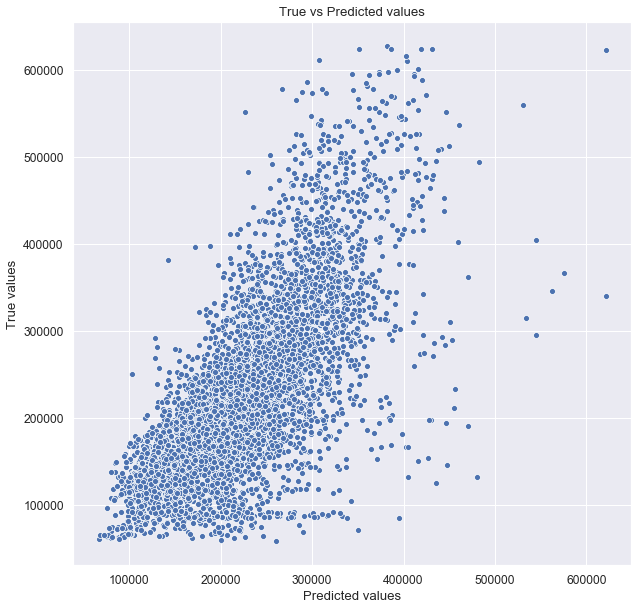

R2:	0.513
MAE:	43901.663
MSE:	4075112822.946


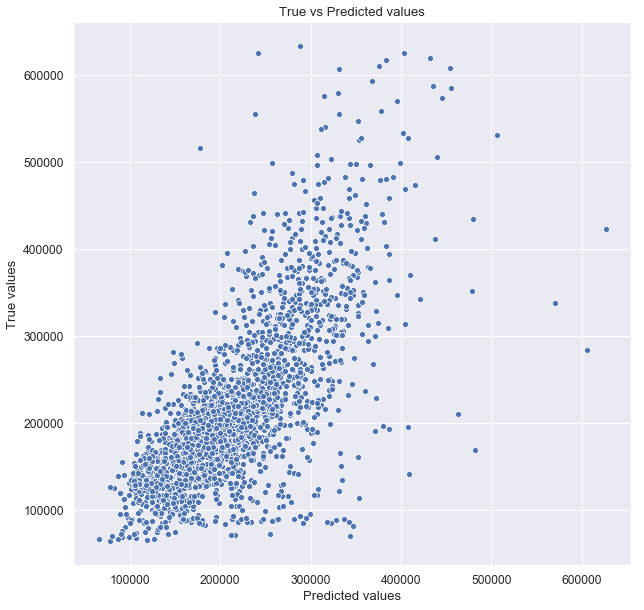

In [78]:
y_pred_l=l_model.predict(X_train)
evaluate_preds(y_train, y_pred_l)

y_pred_lt=l_model.predict(X_test)
evaluate_preds(y_test, y_pred_lt)

Random Forest

R2:	0.948
MAE:	12110.148
MSE:	444337614.405


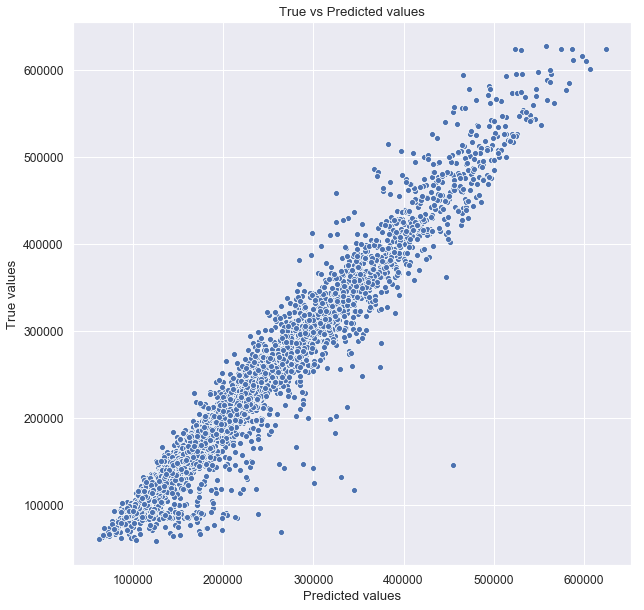

R2:	0.705
MAE:	29676.718
MSE:	2468757149.289


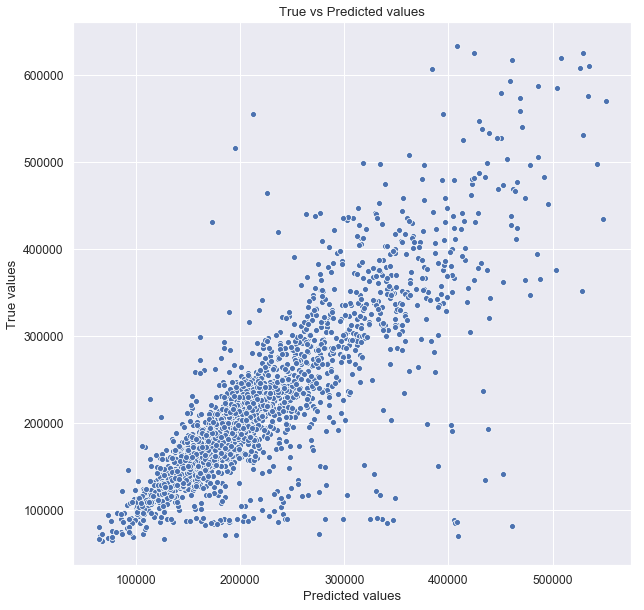

In [79]:
R_model = RandomForestRegressor()
R_model.fit(X_train,y_train)

y_pred_R=R_model.predict(X_train)
evaluate_preds(y_train, y_pred_R)

y_pred_Rt=R_model.predict(X_test)
evaluate_preds(y_test, y_pred_Rt)

Gradient Boosting

R2:	0.766
MAE:	28953.234
MSE:	2001492047.881


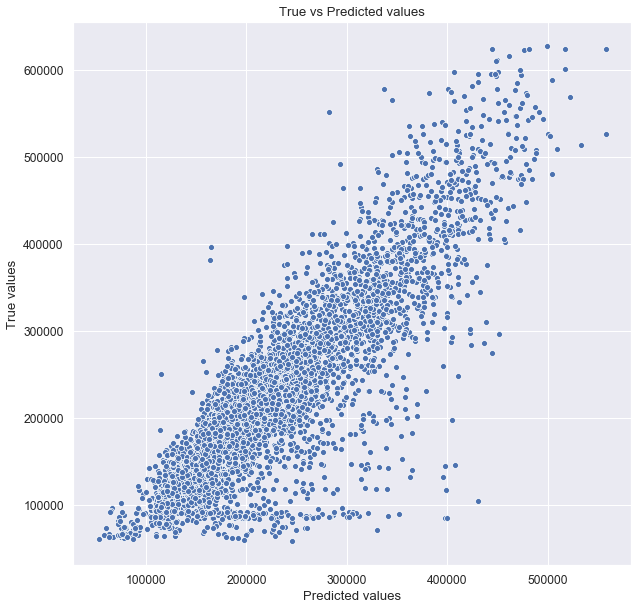

R2:	0.704
MAE:	30813.412
MSE:	2478435176.611


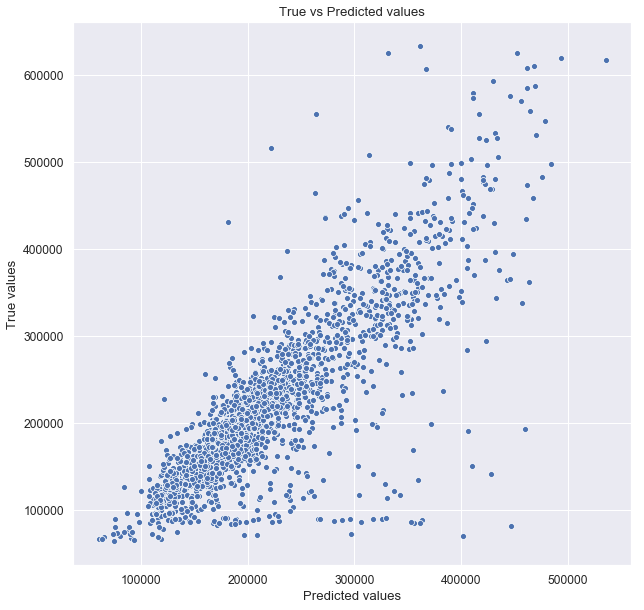

In [80]:
G_model = GradientBoostingRegressor()
G_model.fit(X_train,y_train)

y_pred_G=G_model.predict(X_train)
evaluate_preds(y_train, y_pred_G)

y_pred_Gt=G_model.predict(X_test)
evaluate_preds(y_test, y_pred_Gt)

### Настройка и оценка финальной модели

Подбор гиперпараметров

In [81]:
model = GradientBoostingRegressor(random_state=42)
model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [82]:
param={'n_estimators':[10, 50,100, 150,300], 'max_depth':[3,5,7,10]}

In [83]:
gd=GridSearchCV(model, param, scoring='r2',cv = KFold(n_splits=3,random_state = 42))
gd.fit(X,y)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=False),
       error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...te=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 50, 100, 150, 300], 'max_depth': [3, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [84]:
gd.best_params_

{'max_depth': 5, 'n_estimators': 150}

In [85]:
gd.best_score_

0.7290323960036073

In [109]:
model_best = GradientBoostingRegressor(n_estimators = 150,max_depth = 5 ,random_state=42)
model_best.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=150, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

Обучение и оценка модели

R2:	0.88
MAE:	20896.857
MSE:	1025183034.949


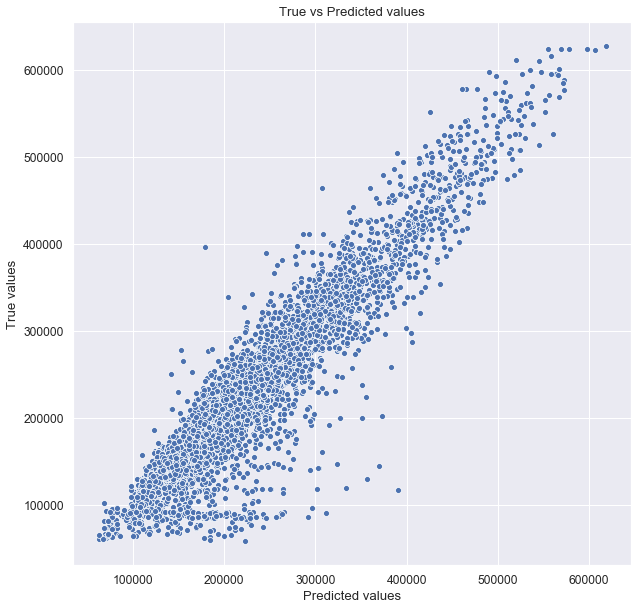

R2:	0.737
MAE:	28000.337
MSE:	2205172860.381


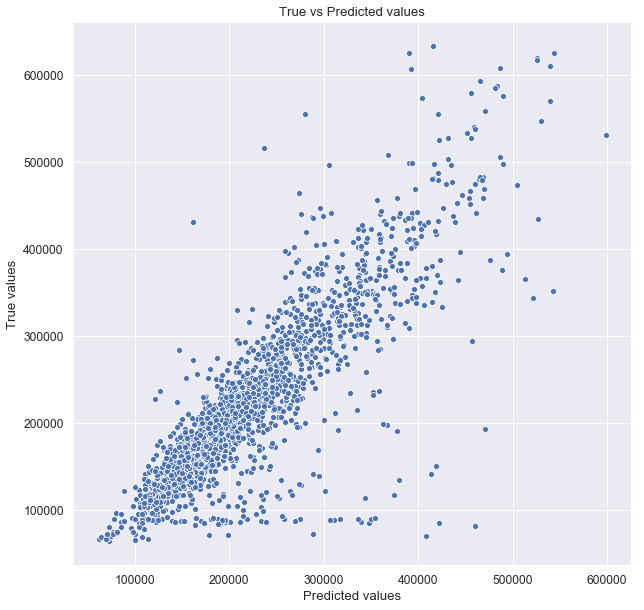

In [110]:
y_pred_=model_best.predict(X_train)
evaluate_preds(y_train, y_pred_)

y_pred_t=model_best.predict(X_test)
evaluate_preds(y_test, y_pred_t)

In [111]:
# Важность признаков
model_best.feature_importances_

array([5.88320630e-02, 6.25999053e-02, 4.22437676e-01, 2.23234690e-02,
       2.33846299e-02, 1.37726460e-02, 2.15112734e-02, 3.39597328e-02,
       4.28258617e-02, 8.55749917e-02, 9.14629314e-02, 7.72253527e-02,
       2.33536270e-02, 5.63630010e-03, 1.33540651e-02, 3.74768925e-05,
       4.64178770e-04, 4.52064582e-04, 5.06819214e-04, 1.98063259e-04,
       8.68723413e-05])

In [113]:
# Сохранение - scaller
with open(SCALER_FILE_PATH,'wb') as file:
    pickle.dump(scl, file)

In [114]:
# Сохранение - model
with open(MODEL_FILE_PATH,'wb') as file:
    pickle.dump(model_best, file)